Import TTF fonts and output training data: a series of point deltas (dx, dy) along with booleans for pen-up/pen-down and next-glyph.

In [20]:
from enum import Enum, IntEnum
import math
import os
import glob
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image, ImageDraw, ImageChops, ImageFont
from IPython.display import display
import tensorflow as tf
print(np.__version__)
print(tf.__version__)
np.set_printoptions(precision=2)

1.14.2
1.10.0


In [0]:
def renderGlyphs(gls, max_points_per_scanline, ygrid):
    '''
    Pure tensorflow function
    Input: 2D tensor of glyph * outlines (dx,dy)
    Output: glyph * matrix of sorted x coords for each line per y coording
    '''
    dxs = gls[:,::2]
    dys = gls[:,1::2]
    xs = tf.cumsum(dxs, axis=-1)+1e-2
    ys = tf.cumsum(dys, axis=-1)+1e-2
    visible = tf.logical_or(xs[:,1:]>0,ys[:,1:]>0)
    #offset to create line start x1,y1 to end x2,y2
    x1s = xs[:,:-1]
    x2s = xs[:,1:]
    y1s = ys[:,:-1]
    y2s = ys[:,1:]
    #add 3rd dimension (size=1) so following interpolation in y is broadcast across all lines
    xx1s=tf.expand_dims(x1s,-1)
    xx2s=tf.expand_dims(x2s,-1)
    yy1s=tf.expand_dims(y1s,-1)
    yy2s=tf.expand_dims(y2s,-1)
    #interpolate the x coords for all lines at all y coord
    xxs = xx1s + (xx2s-xx1s)*(ygrid-yy1s)/(yy2s-yy1s)
    #zero x coords outside of line y bounds or where dy=0 and for hidden lines
    in_range = tf.logical_or(tf.logical_and(yy1s<ygrid, ygrid<=yy2s), tf.logical_and(yy2s<ygrid, ygrid<=yy1s))
    in_range = tf.logical_and(in_range, yy2s!=yy1s)
    in_range = tf.logical_and(in_range, tf.expand_dims(visible,-1))
    xxs = tf.where(in_range, xxs, tf.zeros_like(xxs)) 
    return tf.nn.top_k(tf.transpose(xxs, perm=(0,2,1)),max_points_per_scanline).values

In [0]:
#Read Font outlines from local font files and write outlines to file for fitting
from fontTools.ttLib import TTFont  #pip install fonttools

def GetCoordinates(font, glyphName):
    """font, glyphName --> glyph coordinates as expected by "gvar" table
    The result includes four "phantom points" for the glyph metrics,
    as mandated by the "gvar" spec.
    Function from https://github.com/fonttools/fonttools/blob/master/Snippets/interpolate.py
    By inspection coords[0] are all points, and coords[1] are the end of the ranges for each contour (shape)
    """
    glyphTable = font["glyf"]
    glyph = glyphTable.glyphs.get(glyphName)
    if glyph is None:
        return None
    glyph.expand(glyphTable)
    glyph.recalcBounds(glyphTable)
    coords = glyph.getCoordinates(glyphTable)
    start=0
    contours = []
    for end in coords[1]:
        contours.append(coords[0][start:end+1])
        start=end+1
    return contours

def readFonts(files, glyphs, max_outline_points, y_divisions):
    glyphinputs = np.identity(len(glyphs), dtype=float)  #input is one-hot vec, one per glyph
    print('loading {} files'.format(len(files)))
    inputs = []
    outlines = []
    for i, fontfile in enumerate(files):
        print('loading {}'.format(fontfile))
        fontvec = np.zeros(len(files))
        fontvec[i]=1
        inputs.append(np.concatenate((glyphinputs, np.broadcast_to(fontvec, (glyphinputs.shape[0],fontvec.shape[0]))), axis=1))
        outlines.append(generateOutlines(fontfile, glyphs, max_outline_points, y_divisions))
    return np.concatenate(inputs), np.concatenate(outlines)

class InputVector(IntEnum):
    """
    Enum defining data contents of last dimension
    """
    DX = 0
    DY = 1
    PenDown = 2  # +1 draw stroke, 0 if this stroke is hidden, i.e. to move between contours in the glyph
    EndOfGlyph = 3  # +1 indicates this stroke is the last of the current glyph, else 0
    Size = 4  # size of this enum
    
def generateOutlines(fontfile, glyphs, max_outline_points, y_divisions):
    """
    Read the actual points from all glyphs in the font into numpy array.
    Output is array of glyphs x points x 2 (angle in radians, distance).
    We use float not the original ints from the font - according to https://github.com/fchollet/keras/issues/2218.
    """
    font = TTFont(fontfile)
    unitsPerEm = font['head'].unitsPerEm * 0.9
    numglyphs = len(glyphs)
    outlines = np.zeros((numglyphs, max_outline_points, InputVector.Size), np.float32)
    for i, letter in enumerate(glyphs):
        contours = GetCoordinates(font, letter)
        j = 0
        startp = (0,0.1)
        #ttx contours are areas within the glyph, like the outside and inside outlines of an O
        for xy in contours:
            #fill output matrix, start with hidden line to start position
            outlines[i,j,InputVector.DX] = (xy[0][0]-startp[0])/ unitsPerEm
            outlines[i,j,InputVector.DY] = (xy[0][1]-startp[1])/ unitsPerEm
            outlines[i,j,InputVector.PenDown] = 0
            j = j+1
            if j>=max_outline_points: break
            startp = xy[0]
            #then between points
            for n in range(len(xy)-1):
                outlines[i,j,InputVector.DX] = (xy[n+1][0]-xy[n][0])/ unitsPerEm
                outlines[i,j,InputVector.DY] = (xy[n+1][1]-xy[n][1])/ unitsPerEm
                outlines[i,j,InputVector.PenDown] = 1
                j = j+1
                if j>=max_outline_points: break
            if j>=max_outline_points: break
            #finally wrap last point to first in contour
            N=len(xy)-1
            outlines[i,j,InputVector.DX] = (xy[0][0]-xy[N][0])/ unitsPerEm
            outlines[i,j,InputVector.DY] = (xy[0][1]-xy[N][1])/ unitsPerEm
            outlines[i,j,InputVector.PenDown] = 1
            j = j+1
            if j>=max_outline_points: break
        outlines[i,:j,InputVector.EndOfGlyph] = 1
    return outlines

In [0]:
def drawOutlines(outlines, cellsize):
    """Draw numpy array interpreted as a glyph per row and each row containing x,y or angle,dist pairs."""
    columns = math.ceil(800/cellsize)
    rows = math.ceil(outlines.shape[0]/columns)
    def drawPoints(im, points, cellx, celly):
        #temporary image to use to xor each part with main image
        im2 = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
        draw = ImageDraw.Draw(im2) 
        draw.polygon(points, fill=1)
        im = ImageChops.logical_xor(im, im2)
        return im
    scale = cellsize * 0.9
    im = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
    for i in range(outlines.shape[0]):
        celly,cellx = divmod(i, columns)
        cellx *= cellsize
        celly *= cellsize
        points = []
        x,y=(0,cellsize-1)
        for j in range(outlines.shape[1]):
            if outlines[i][j][InputVector.EndOfGlyph]<0.5: 
                break;
            x += outlines[i][j][InputVector.DX]*scale
            y -= outlines[i][j][InputVector.DY]*scale
            if outlines[i][j][InputVector.PenDown]>0.5:
                points += (cellx+x,celly+y)
            elif len(points)>2:
                im = drawPoints(im, points, cellx, celly)
                points=[]
        if len(points)>2:
            im = drawPoints(im, points, cellx, celly)
    return im

def drawXYs(xxs, ygrid, cellsize):
    '''Draw a glyph rasterisation based on a input y coord array with array of x-intercepts of lines with the y coord'''
    columns = math.ceil(800/cellsize)
    rows = math.ceil(xxs.shape[0]/columns)
    scale = cellsize * 0.9
    im = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
    draw = ImageDraw.Draw(im) 
    for i in range(xxs.shape[0]):
        yy,xx = divmod(i, columns)
        xx *= cellsize
        yy = (yy+1)*cellsize-1
        for xs, y in zip(xxs[i], ygrid):
            for x in xs:
                if x>0.0:
                    draw.ellipse((xx+x*scale, yy-y*scale, xx+x*scale+3, yy-y*scale+3), fill=1)
    return im

setup...
loading 4 files
loading deeper/fonts\Courier Prime Bold Italic.ttf
loading deeper/fonts\Courier Prime Bold.ttf
loading deeper/fonts\Courier Prime Italic.ttf
loading deeper/fonts\Courier Prime.ttf
[0.27 0.53 0.   1.  ]
input shape (glyphs, characters+fonts):  (248, 66)
outline shape (glyphs, max_points_per_scanline, InputVector):  (248, 110, 4)


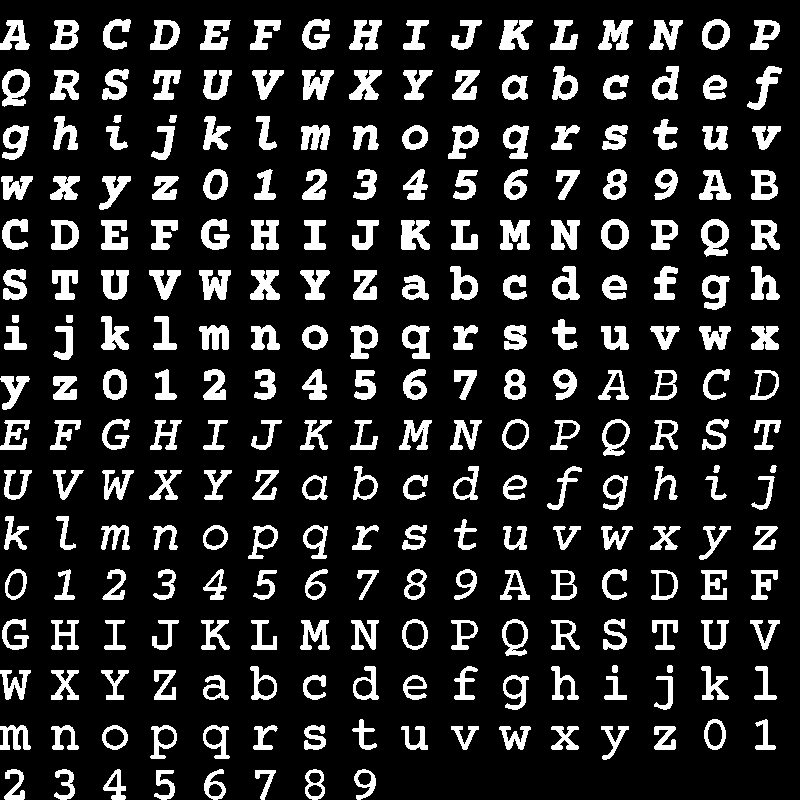

In [24]:
print('setup...')
glyphs = [chr(i) for i in range(ord('A'), ord('Z')+1)]
glyphs += [chr(i) for i in range(ord('a'), ord('z')+1)]
glyphs += ['zero','one','two','three','four','five','six','seven','eight','nine']
#glyphs = ['A','B','a','b','one','two']
#glyphs = ['A']
max_points_per_scanline = 10 # required for g, m
max_outline_points = 110
y_divisions = 30
ygrid = np.linspace(0.0, 1.0, y_divisions, endpoint=False) #y coordinates to render on
files = glob.glob('deeper/fonts/Courier*.ttf')
inputs, outlines = readFonts(files, glyphs, max_outline_points, y_divisions)
batch_size = outlines.shape[0]
print(outlines[0,0])
#inputs = np.identity(len(glyphs), dtype=float)  #input is one-hot vec, one per glyph
#outlines = generateOutlines('deeper/Courier Prime.ttf', glyphs, max_outline_points, ygrid)
print("input shape (glyphs, characters+fonts): ", inputs.shape)
print("outline shape (glyphs, max_points_per_scanline, InputVector): ", outlines.shape)
#with tf.Session() as sess:
#    xcoords = renderGlyphs(outlines, max_points_per_scanline, ygrid).eval()
    #print(xcoords)
#    print("output shape: ", xcoords.shape)
cellsize = 50
drawOutlines(outlines, cellsize)
#display(drawOutlines(outlines, cellsize), drawXYs(xcoords, ygrid, cellsize))